# Resultados

In [ ]:
!pip install matplotlib
!pip install pandas 

In [5]:
import matplotlib.pylab as plt
from matplotlib.pylab import cm
from matplotlib import colors as mcolors
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List
import itertools

In [101]:
# Cargar datos y eliminar outliers

def eliminar_outliers(df: pd.DataFrame, columna: str, umbral: float) -> pd.DataFrame:
    return df[df[columna] <= umbral]

df_dqn = pd.read_csv('resultados/resultados_arco_de_entrenamiento_DQN.csv')
df_lstm = pd.read_csv('resultados/resultados_arco_de_entrenamiento_A2C_LSTM.csv')
df_ql = pd.read_csv('resultados/resultados_arco_de_entrenamiento_QLearning.csv')
df_dueling = pd.read_csv('resultados/resultados_arco_de_entrenamiento_duelingDQN.csv')
df_a2c = pd.read_csv('resultados/resultados_arco_de_entrenamiento_A2C.csv')

df_lstm = eliminar_outliers(df_lstm, 'perdida', 200)
df_dqn = eliminar_outliers(df_dqn, 'perdida', 200)


data_entrenamiento_perdida = [(df_dqn, "DeepQ Network"), (df_lstm, "A2C LSTM"), (df_dueling, 'DuelingDQN'), (df_a2c, "A2C")]   
data_entrenamiento_exploracion = [(df_ql, "Q-Learning")]   

## Graficos Entrenamiento

In [102]:
# Graficar el progreso de entrenamiento
cmap = cm.plasma    


def plot_perdida_por_torneo(df, titulo, puntos=False):
    
    # Promedio por torneo
    prom = df.groupby('n_torneo')['perdida'].mean().reset_index()

    
    plt.figure(figsize=(12, 6))

    # Línea del promedio por torneo
    plt.plot(prom['n_torneo'], prom['perdida'], color='black', label='Promedio por torneo')


    # Puntos coloreados por magnitud de pérdida
    if puntos:
        # Normalización robusta sobre los valores a graficar (promedios)
        vals = prom['perdida'].values
        vmin = float(vals.min()) if len(vals) else 0.0
        vmax = float(vals.max()) if len(vals) else 1.0
        # Evitar rango cero (todos iguales)
        if vmax == vmin:
            vmax = vmin + 1e-12
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

        colors = cmap(norm(vals))

        sc = plt.scatter(
            prom['n_torneo'],
            prom['perdida'],
            c=prom['perdida'],
            cmap=cmap,
            s=100,
            norm=norm
        )
        # Barra de color
        cbar = plt.colorbar(sc)
        cbar.set_label('Pérdida')

    plt.title(titulo)
    plt.xlabel('Número de torneo')
    plt.ylabel('Pérdida (loss)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()


    plt.legend()
    plt.show()




def plot_exploracion_por_torneo(df, titulo, puntos=False):
    
    # Promedio por torneo
    prom = df.groupby('n_torneo')['exploracion'].mean().reset_index()

    # Normalización robusta sobre los valores a graficar (promedios)
    vals = prom['exploracion'].values
    vmin = float(vals.min()) if len(vals) else 0.0
    vmax = float(vals.max()) if len(vals) else 1.0
    
    # Evitar rango cero (todos iguales)
    if vmax == vmin:
        vmax = vmin + 1e-12
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    colors = cmap(norm(vals))

    plt.figure(figsize=(12, 6))

    # Línea del promedio por torneo
    plt.plot(prom['n_torneo'], prom['exploracion'], color='black', label='Promedio por torneo')

    # Puntos coloreados por magnitud de pérdida

    if puntos:
        sc = plt.scatter(
            prom['n_torneo'],
            prom['exploracion'],
            c=prom['exploracion'],
            cmap=cmap,
            s=100,
            norm=norm
        )
        # Barra de color
        cbar = plt.colorbar(sc)
        cbar.set_label('Exploración')

    plt.title(titulo)
    plt.xlabel('Número de torneo')
    plt.ylabel('Exploración')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()


    plt.legend()
    plt.show()


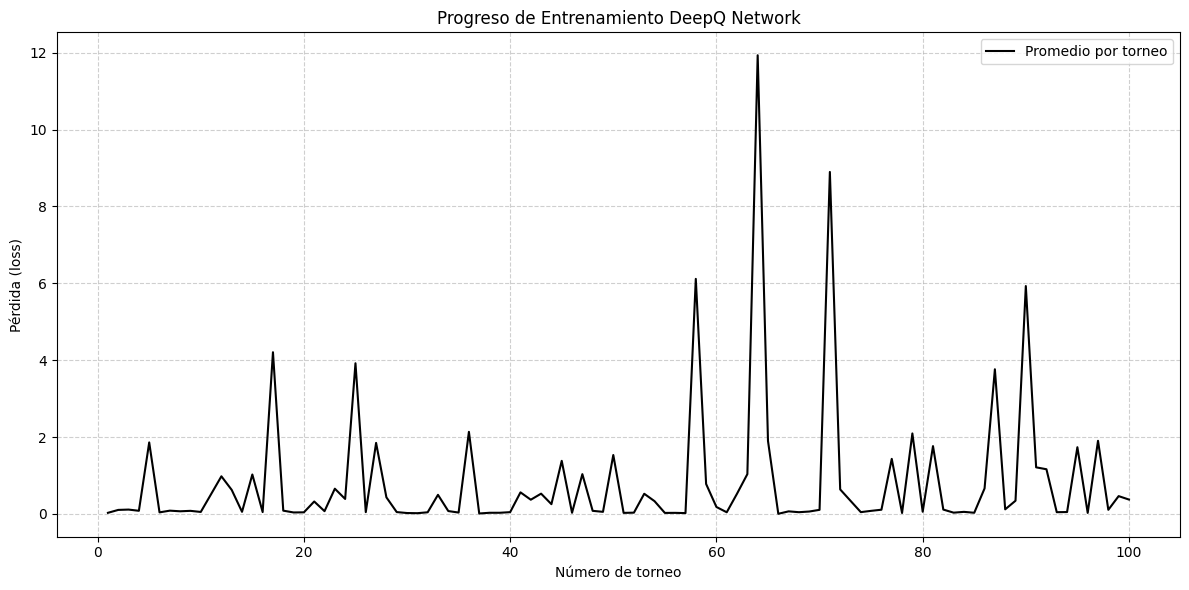

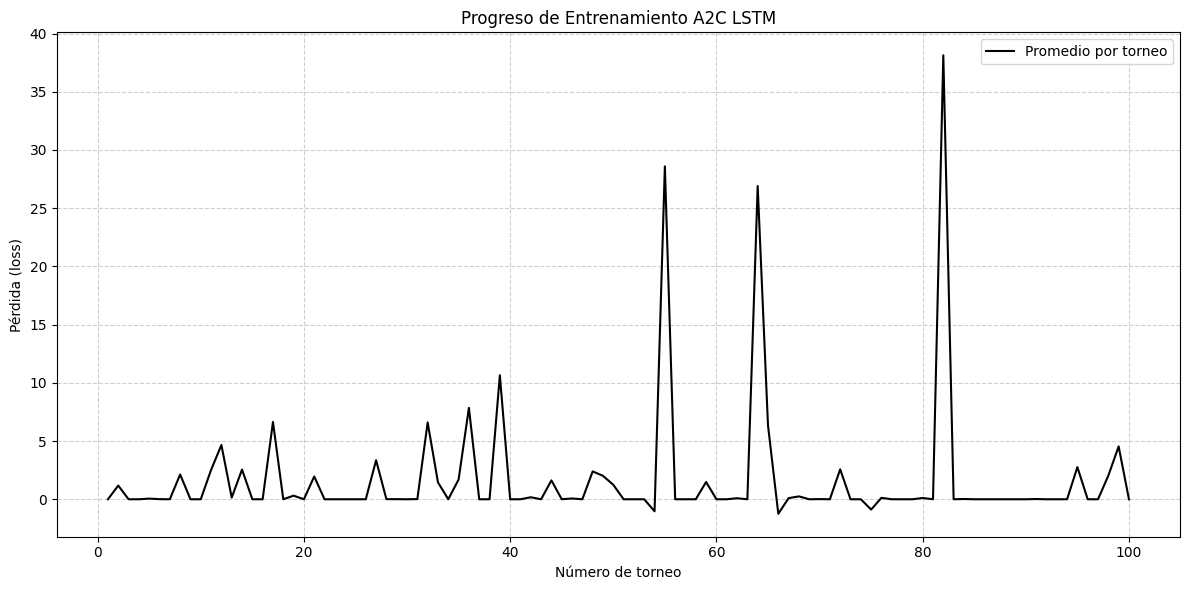

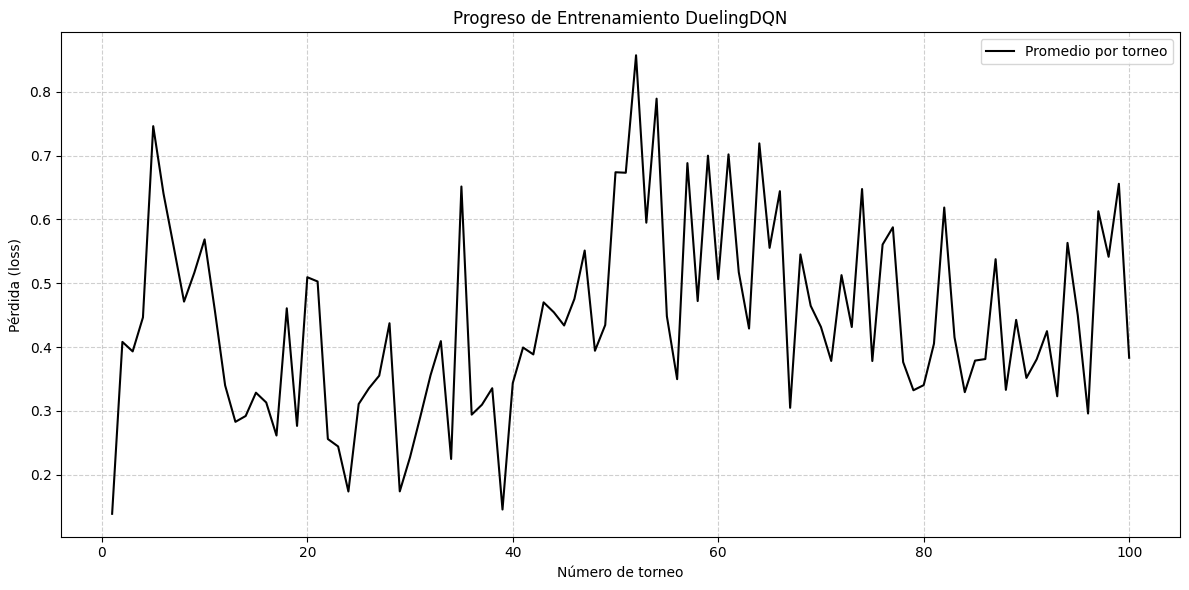

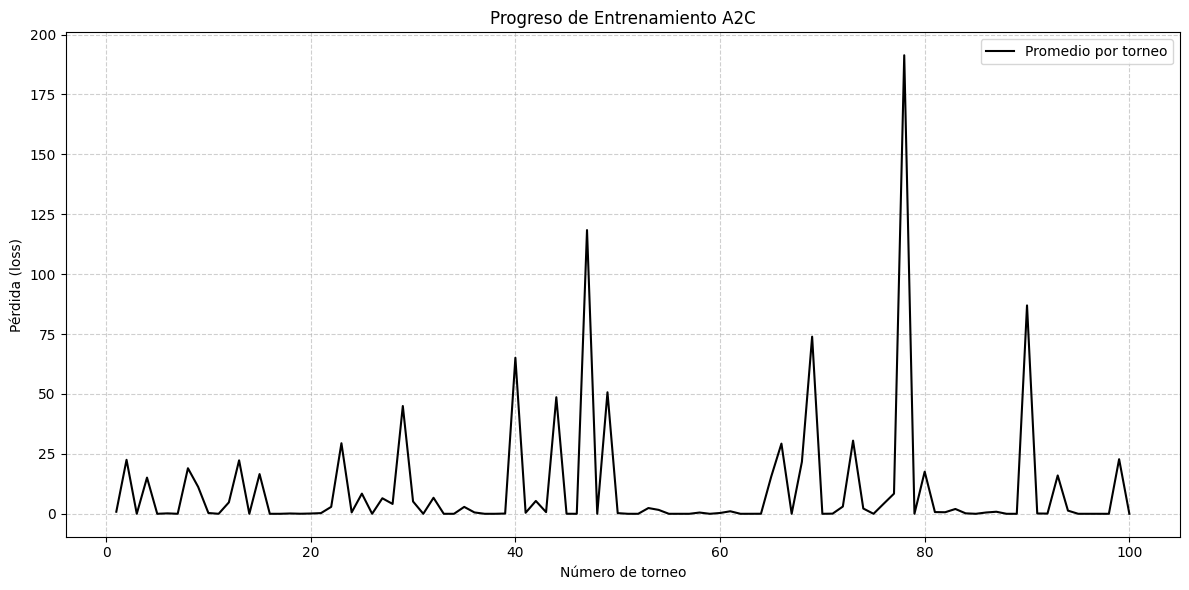

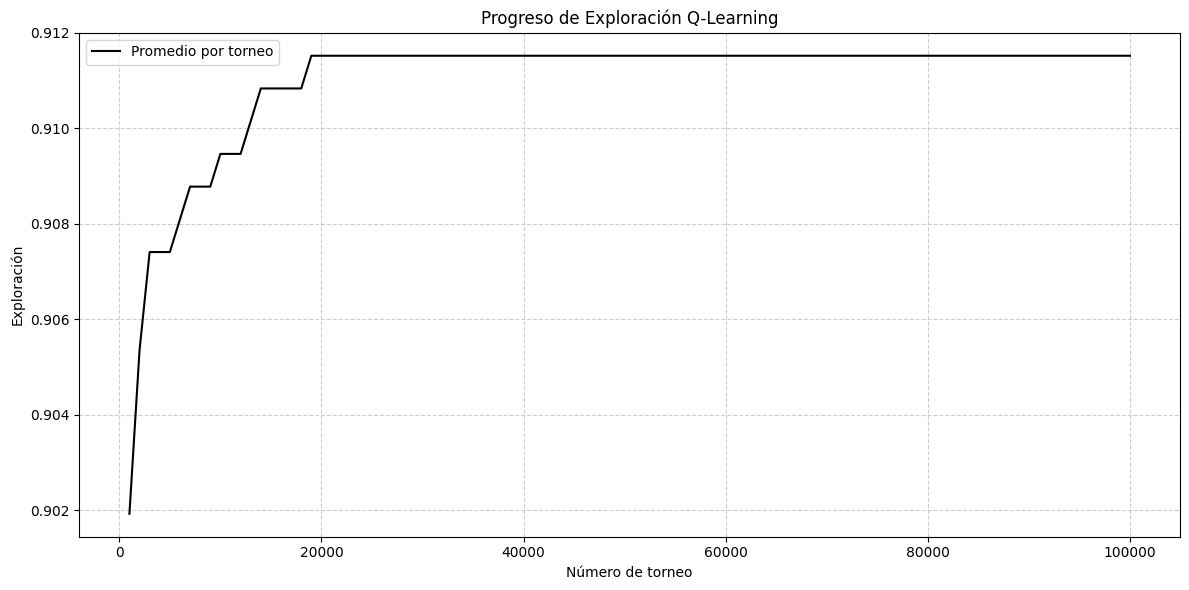

In [103]:
# Graficar progreso de entrenamiento para cada archivo
for f, nombre in data_entrenamiento_perdida:
    plot_perdida_por_torneo(f, f"Progreso de Entrenamiento {nombre}", puntos=False)

for f, nombre in data_entrenamiento_exploracion:
    plot_exploracion_por_torneo(f, f"Progreso de Exploración {nombre}", puntos=False)

## Gráficos Experimentación

In [124]:

torneo_dqn = pd.read_csv('resultados/resultado_DQN.csv')
torneo_lstm = pd.read_csv('resultados/resultado_A2C_LSTM.csv')
torneo_ql = pd.read_csv('resultados/resultado_QL.csv')
torneo_dueling = pd.read_csv('resultados/resultado_DuelingDQN.csv')
torneo_a2c = pd.read_csv('resultados/resultado_A2C.csv')

In [125]:
# Función: Comparativa acumulado ___ vs agentes clásicos (solo gráfico acumulado)


def plot_comparativa_puntaje_acumulado(
    df_scores,
    destacado: List[str] = [],
    titulo_acumulado: str = 'Puntaje Acumulado: ___ vs agentes clásicos'
) -> Tuple[dict, dict, Dict[str, str]]:
    """
    Traza un único gráfico con el puntaje acumulado del/los
    agentes destacados contra el resto.

    Parámetros
    ----------
    df_scores : pandas.DataFrame
        Filas representan torneos (en orden) y columnas representan agentes.
    destacado : List[str]
        Lista de nombres de agentes a resaltar (case-insensitive).
    titulo_acumulado : str
        Título del gráfico de puntaje acumulado.

    Retorna
    -------
    (promedios, acumulados, colores_destacados) : Tuple[dict, dict, Dict[str, str]]
        Diccionarios con el promedio y el acumulado por agente, y un mapping
        agente_destacado -> color usado en los gráficos.
    """

    if not isinstance(df_scores, pd.DataFrame):
        raise ValueError('df_scores debe ser un pandas.DataFrame')
    if df_scores.empty:
        raise ValueError('df_scores está vacío')

    # Detectar columnas correspondientes a destacados para resaltarlas
    cols = list(df_scores.columns)
    destacado_norm = [d.strip().lower() for d in destacado]
    destacado_like: List[str] = []
    for c in cols:
        if c.lower() in destacado_norm:
            destacado_like.append(c)

    otros = [c for c in cols if c not in destacado_like]

    # Paleta de colores distinta por destacado
    tab10 = list(plt.get_cmap('tab10').colors)
    if len(tab10) == 0:
        tab10 = [
            (0.1216, 0.4667, 0.7059),
            (1.0000, 0.4980, 0.0549),
            (0.1725, 0.6275, 0.1725),
            (0.8392, 0.1529, 0.1569),
            (0.5804, 0.4039, 0.7412),
            (0.5490, 0.3373, 0.2941),
            (0.8902, 0.4667, 0.7608),
            (0.4980, 0.4980, 0.4980),
            (0.7373, 0.7412, 0.1333),
            (0.0902, 0.7451, 0.8118),
        ]

    color_cycle = itertools.cycle(tab10)
    colores_destacados: Dict[str, str] = {}
    for col in destacado_like:
        c_rgba = next(color_cycle)
        colores_destacados[col] = '#%02x%02x%02x' % (
            int(c_rgba[0] * 255), int(c_rgba[1] * 255), int(c_rgba[2] * 255)
        )

    # --- Resumen numérico ---
    promedios = df_scores.mean().to_dict()
    acumulados = df_scores.sum().to_dict()

    # --- Gráfico único: puntaje acumulado ---
    df_cum = df_scores.cumsum()

    fig, ax2 = plt.subplots(1, 1, figsize=(12, 6))

    for col in otros:
        ax2.plot(
            df_cum.index + 1,
            df_cum[col],
            label=col + ' (acum.)',
            linewidth=1.2,
            alpha=0.55,
            zorder=1
        )

    for col in destacado_like:
        ax2.plot(
            df_cum.index + 1,
            df_cum[col],
            label=col + ' (acum.)',
            color=colores_destacados[col],
            linewidth=3.0,
            marker="o",
            markersize=4,
            zorder=5
        )
        y_last = df_cum[col].iloc[-1] if len(df_cum[col]) > 0 else None
        if y_last is not None:
            ax2.annotate(
                col + ' (acum.)',
                xy=(len(df_cum), y_last),
                xytext=(6, 0),
                textcoords="offset points",
                color=colores_destacados[col],
                weight="bold",
                va="center"
            )

    ax2.set_title(titulo_acumulado)
    ax2.set_xlabel('Torneo')
    ax2.set_ylabel('Puntaje acumulado')
    ax2.grid(True, linestyle='--', alpha=0.6)

    handles2, labels2 = ax2.get_legend_handles_labels()
    order2 = ([i for i, l in enumerate(labels2) if any(dl in l for dl in destacado_like)] +
              [i for i, l in enumerate(labels2) if not any(dl in l for dl in destacado_like)])
    handles2 = [handles2[i] for i in order2]
    labels2 = [labels2[i] for i in order2]
    ax2.legend(handles2, labels2, ncol=2, frameon=True, framealpha=0.9)

    fig.tight_layout()
    plt.show()

    return promedios, acumulados, colores_destacados

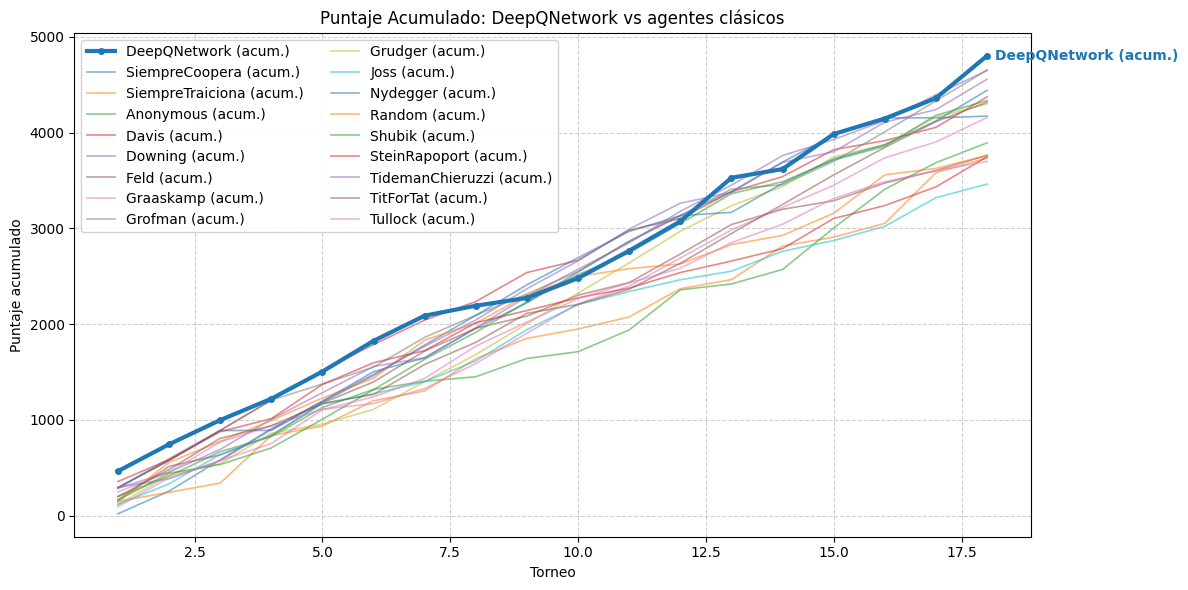

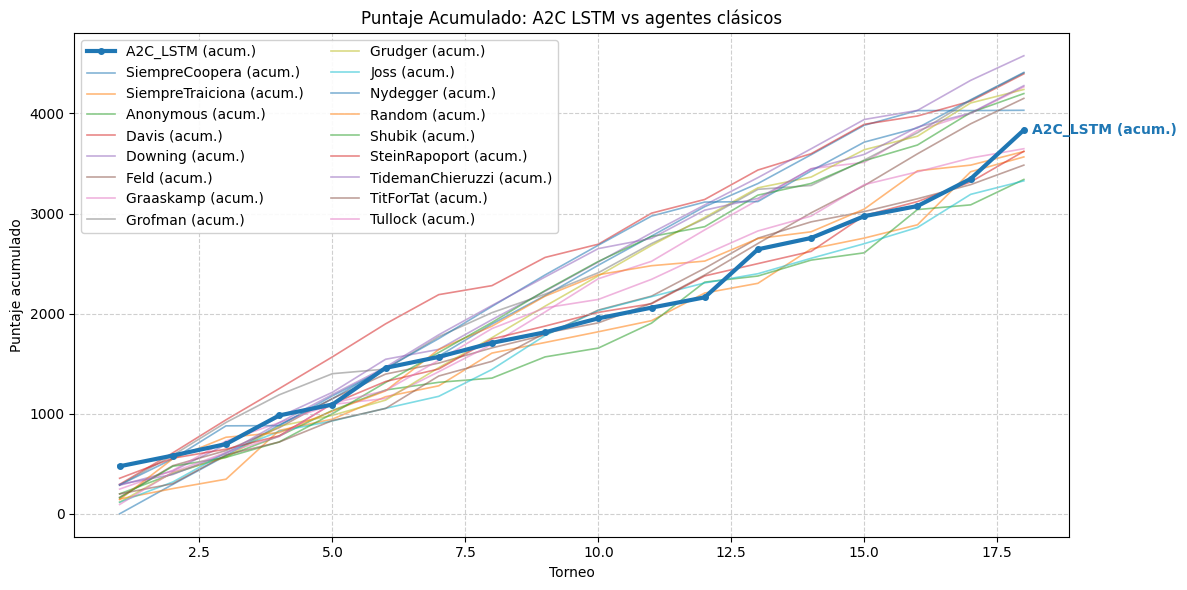

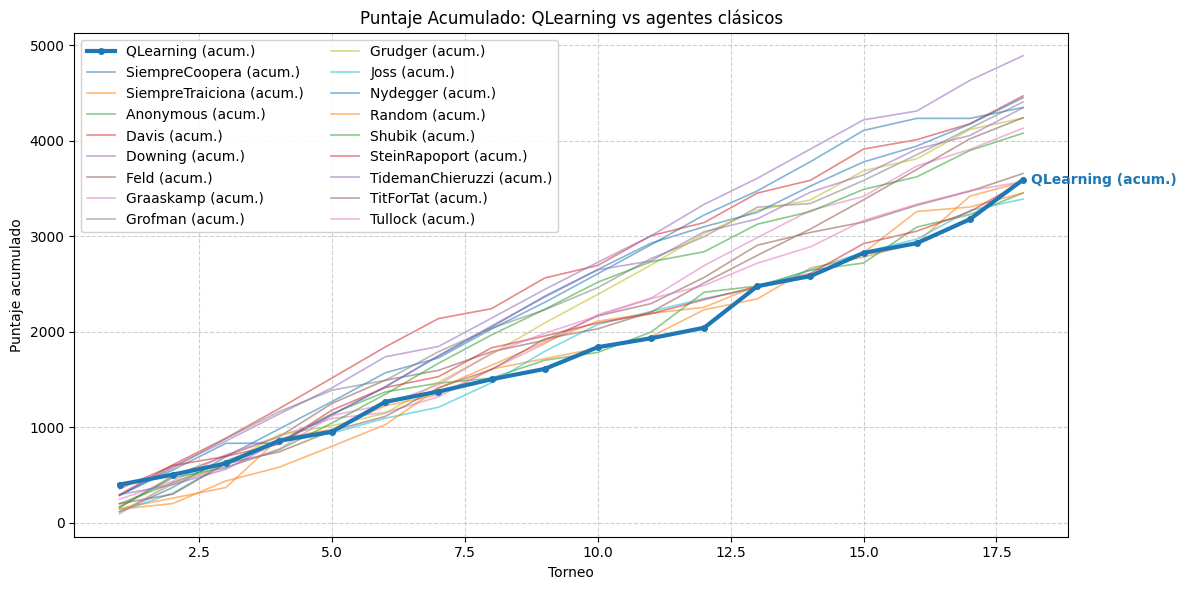

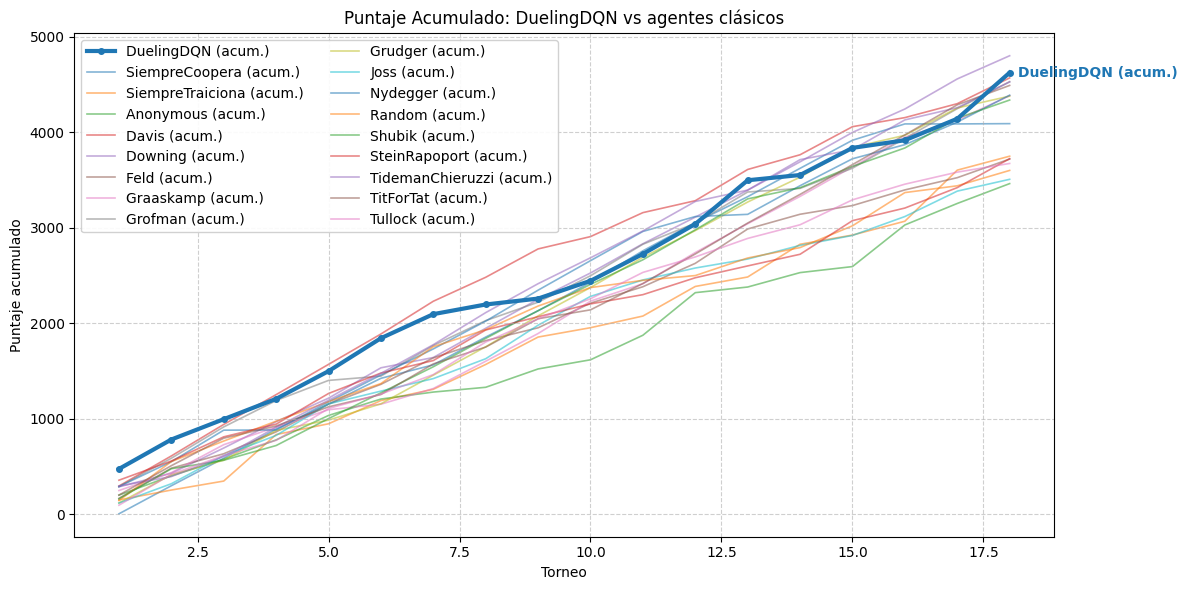

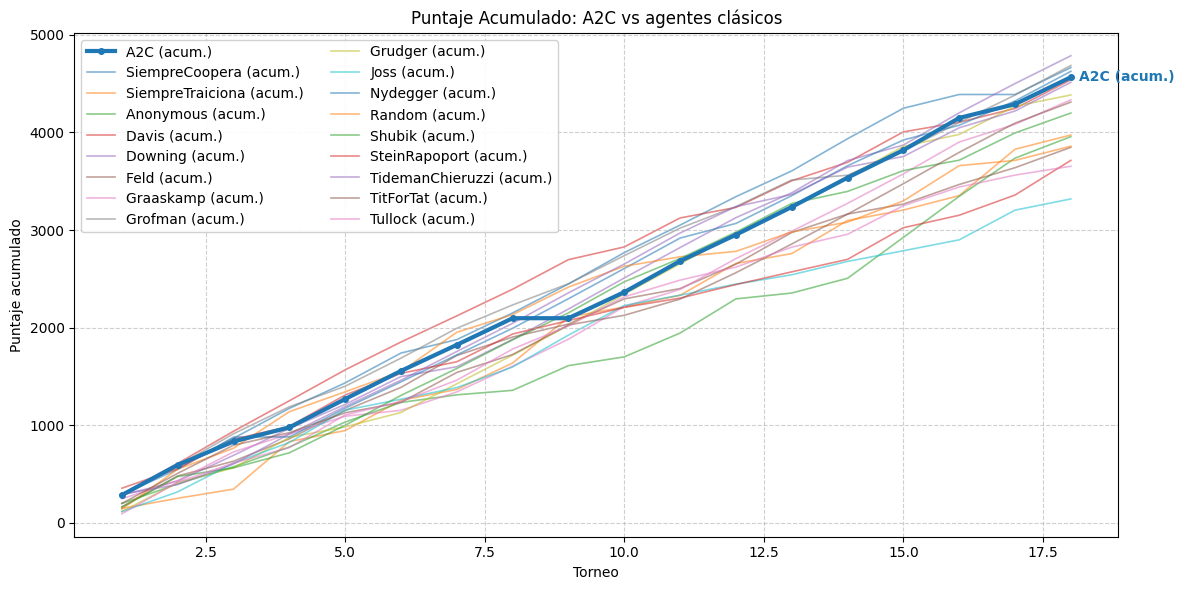

In [126]:
# Ejemplo de uso de la función con destacados (solo acumulado)
promedios, acumulados, colores = plot_comparativa_puntaje_acumulado(
    torneo_dqn,
    destacado=['DeepQNetwork'],
    titulo_acumulado='Puntaje Acumulado: DeepQNetwork vs agentes clásicos'
)

promedios, acumulados, colores = plot_comparativa_puntaje_acumulado(
    torneo_lstm,
    destacado=['A2C_LSTM'],
    titulo_acumulado='Puntaje Acumulado: A2C LSTM vs agentes clásicos'
)

promedios, acumulados, colores = plot_comparativa_puntaje_acumulado(
    torneo_ql,
    destacado=['QLearning'],
    titulo_acumulado='Puntaje Acumulado: QLearning vs agentes clásicos'
)

promedios, acumulados, colores = plot_comparativa_puntaje_acumulado(
    torneo_dueling,
    destacado=['DuelingDQN'],
    titulo_acumulado='Puntaje Acumulado: DuelingDQN vs agentes clásicos'
)

promedios, acumulados, colores = plot_comparativa_puntaje_acumulado(
    torneo_a2c,
    destacado=['A2C'],
    titulo_acumulado='Puntaje Acumulado: A2C vs agentes clásicos'
)

In [127]:

def plot_comparativa_estrategias(
    df_scores,
    destacado: List[str] = [],
    titulo_por_torneo: str = 'Puntaje por Torneo: ___ vs agentes clásicos',
    titulo_acumulado: str = 'Puntaje Acumulado: ___ vs agentes clásicos'
) -> Tuple[dict, dict, Dict[str, str]]:
    """
    Traza dos gráficos comparando el desempeño por torneo y acumulado del/los
    agentes destacados contra el resto en una misma figura (dos subplots).

    Parámetros
    ----------
    df_scores : pandas.DataFrame
        Filas representan torneos (en orden) y columnas representan agentes.
    destacado : List[str]
        Lista de nombres de agentes a resaltar (case-insensitive).
    titulo_por_torneo : str
        Título del gráfico de puntaje por torneo.
    titulo_acumulado : str
        Título del gráfico de puntaje acumulado.

    Retorna
    -------
    (promedios, acumulados, colores_destacados) : Tuple[dict, dict, Dict[str, str]]
        Diccionarios con el promedio y el acumulado por agente, y un mapping
        agente_destacado -> color usado en los gráficos.
    """

    if not isinstance(df_scores, pd.DataFrame):
        raise ValueError('df_scores debe ser un pandas.DataFrame')
    if df_scores.empty:
        raise ValueError('df_scores está vacío')

    # Detectar columnas correspondientes a destacados para resaltarlas
    cols = list(df_scores.columns)
    # normalizamos entradas
    destacado_norm = [d.strip().lower() for d in destacado]
    destacado_like: List[str] = []
    for c in cols:
        if c.lower() in destacado_norm:
            destacado_like.append(c)

    otros = [c for c in cols if c not in destacado_like]

    # Paleta de colores distinta por destacado
    # Usamos 'tab10' y si hay más de 10, repetimos con variaciones
    tab10 = list(plt.get_cmap('tab10').colors)
    if len(tab10) == 0:
        tab10 = [
            (0.1216, 0.4667, 0.7059),
            (1.0000, 0.4980, 0.0549),
            (0.1725, 0.6275, 0.1725),
            (0.8392, 0.1529, 0.1569),
            (0.5804, 0.4039, 0.7412),
            (0.5490, 0.3373, 0.2941),
            (0.8902, 0.4667, 0.7608),
            (0.4980, 0.4980, 0.4980),
            (0.7373, 0.7412, 0.1333),
            (0.0902, 0.7451, 0.8118),
        ]

    color_cycle = itertools.cycle(tab10)
    colores_destacados: Dict[str, str] = {}
    for col in destacado_like:
        c_rgba = next(color_cycle)
        # Convertimos a hex para consistencia
        colores_destacados[col] = '#%02x%02x%02x' % (
            int(c_rgba[0] * 255), int(c_rgba[1] * 255), int(c_rgba[2] * 255)
        )

    # --- Preparar figura con dos subplots ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), sharex=False)

    # --- Subplot 1: puntaje por torneo ---
    # Otros en estilo tenue
    for col in otros:
        ax1.plot(
            df_scores.index + 1,
            df_scores[col],
            label=col,
            linewidth=1.2,
            alpha=0.55,
            zorder=1
        )

    # Destacados con color propio
    for col in destacado_like:
        ax1.plot(
            df_scores.index + 1,
            df_scores[col],
            label=col,
            color=colores_destacados[col],
            linewidth=3.0,
            marker="o",
            markersize=4,
            zorder=5
        )
        y_last = df_scores[col].iloc[-1] if len(df_scores[col]) > 0 else None
        if y_last is not None:
            ax1.annotate(
                col,
                xy=(len(df_scores), y_last),
                xytext=(6, 0),
                textcoords="offset points",
                color=colores_destacados[col],
                weight="bold",
                va="center"
            )

    ax1.set_title(titulo_por_torneo)
    ax1.set_xlabel('Torneo')
    ax1.set_ylabel('Puntaje del torneo')
    ax1.grid(True, linestyle='--', alpha=0.6)

    # handles1, labels1 = ax1.get_legend_handles_labels()
    # order1 = ([labels1.index(c) for c in destacado_like if c in labels1] +
    #           [i for i, l in enumerate(labels1) if l not in destacado_like])
    # handles1 = [handles1[i] for i in order1]
    # labels1 = [labels1[i] for i in order1]
    # ax1.legend(handles1, labels1, ncol=2, frameon=True, framealpha=0.9)

    # --- Resumen numérico ---
    promedios = df_scores.mean().to_dict()
    acumulados = df_scores.sum().to_dict()

    # --- Subplot 2: puntaje acumulado ---
    df_cum = df_scores.cumsum()

    for col in otros:
        ax2.plot(
            df_cum.index + 1,
            df_cum[col],
            label=col + ' (acum.)',
            linewidth=1.2,
            alpha=0.55,
            zorder=1
        )

    for col in destacado_like:
        ax2.plot(
            df_cum.index + 1,
            df_cum[col],
            label=col + ' (acum.)',
            color=colores_destacados[col],
            linewidth=3.0,
            marker="o",
            markersize=4,
            zorder=5
        )
        y_last = df_cum[col].iloc[-1] if len(df_cum[col]) > 0 else None
        if y_last is not None:
            ax2.annotate(
                col + ' (acum.)',
                xy=(len(df_cum), y_last),
                xytext=(6, 0),
                textcoords="offset points",
                color=colores_destacados[col],
                weight="bold",
                va="center"
            )

    ax2.set_title(titulo_acumulado)
    ax2.set_xlabel('Torneo')
    ax2.set_ylabel('Puntaje acumulado')
    ax2.grid(True, linestyle='--', alpha=0.6)

    handles2, labels2 = ax2.get_legend_handles_labels()
    order2 = ([i for i, l in enumerate(labels2) if any(dl in l for dl in destacado_like)] +
              [i for i, l in enumerate(labels2) if not any(dl in l for dl in destacado_like)])
    handles2 = [handles2[i] for i in order2]
    labels2 = [labels2[i] for i in order2]
    ax2.legend(handles2, labels2, ncol=2, frameon=True, framealpha=0.9)

    fig.tight_layout()
    plt.show()

    return promedios, acumulados, colores_destacados

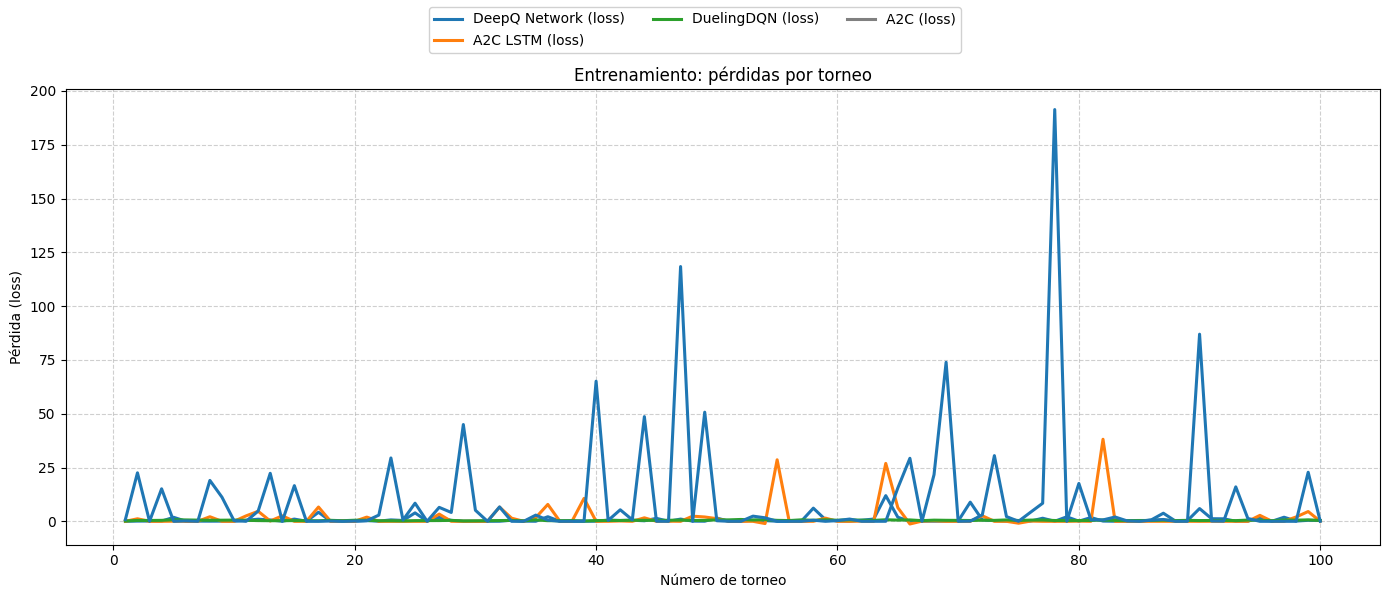

In [128]:
# Gráfico combinado: pérdidas (DQN, A2C LSTM, DuelingDQN)
# Todas en una sola figura con distintos colores (sin Q-Learning).

from matplotlib.lines import Line2D

def plot_combinado_entrenamiento(
    data_perdida,
    titulo: str = 'Entrenamiento: pérdidas por torneo'
):
    """
    Dibuja en una sola figura:
    - Tres series de pérdida promedio por torneo (eje Y de pérdidas):
      DeepQNetwork, A2C LSTM, DuelingDQN

    Parámetros
    ----------
    data_perdida : List[Tuple[pd.DataFrame, str]]
        Lista con tuples (df, nombre) para pérdidas. El df debe tener columnas: 'n_torneo', 'perdida'.
    titulo : str
        Título de la figura.
    """
    # Colores consistentes
    colores = {
        'DeepQ Network': '#1f77b4',   # azul
        'A2C LSTM': '#ff7f0e',        # naranja
        'DuelingDQN': '#2ca02c',      # verde
    }

    fig, ax_loss = plt.subplots(figsize=(14, 6))
    ax_loss.set_title(titulo)
    ax_loss.set_xlabel('Número de torneo')
    ax_loss.set_ylabel('Pérdida (loss)')

    # Plot pérdidas
    handles = []
    for df, nombre in data_perdida:
        prom = df.groupby('n_torneo')['perdida'].mean().reset_index()
        color = colores.get(nombre, None)
        line, = ax_loss.plot(prom['n_torneo'], prom['perdida'], label=f'{nombre} (loss)',
                             color=color, linewidth=2.2)
        handles.append(Line2D([0], [0], color=color or 'gray', lw=2.2, label=f'{nombre} (loss)'))

    ax_loss.grid(True, linestyle='--', alpha=0.6)
    fig.legend(handles=handles, loc='upper center', ncol=3, frameon=True, framealpha=0.9)
    fig.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

# Ejecutar gráfico combinado con las 3 series de pérdida
plot_combinado_entrenamiento(data_entrenamiento_perdida)


In [129]:
# Visualizar cada tabla de torneos
from IPython.display import display

print('Tabla: DeepQNetwork')
display(torneo_dqn)

print('Tabla: A2C LSTM')
display(torneo_lstm)

print('Tabla: Q-Learning')
display(torneo_ql)

print('Tabla: DuelingDQN')
display(torneo_dueling)


Tabla: DeepQNetwork


,SiempreCoopera,SiempreTraiciona,Anonymous,Davis,Downing,Feld,Graaskamp,Grofman,Grudger,Joss,Nydegger,Random,Shubik,SteinRapoport,TidemanChieruzzi,TitForTat,Tullock,DeepQNetwork
0,18,148,199,294,285,165,247,288,116,116,288,142,160,355,294,199,93,463
1,237,95,213,282,168,348,205,306,306,215,288,413,282,228,90,281,302,281
2,327,96,255,312,237,120,316,296,120,307,312,220,91,293,189,327,179,253
3,324,497,157,318,315,204,169,315,318,197,2,218,173,136,324,131,178,223
4,288,99,304,308,279,339,173,169,94,334,294,235,300,358,300,230,354,284
5,309,265,190,273,273,220,60,176,155,103,279,206,309,226,279,98,135,321
6,144,102,85,255,92,323,157,312,291,127,318,399,318,127,291,312,192,263
7,309,337,47,194,312,237,261,231,282,217,309,177,282,291,276,232,337,104
8,267,212,191,303,327,128,317,222,321,327,321,292,317,128,327,303,251,82
9,321,98,71,128,285,218,307,236,321,261,282,198,285,133,291,93,246,206


Tabla: A2C LSTM


,SiempreCoopera,SiempreTraiciona,Anonymous,Davis,Downing,Feld,Graaskamp,Grofman,Grudger,Joss,Nydegger,Random,Shubik,SteinRapoport,TidemanChieruzzi,TitForTat,Tullock,A2C_LSTM
0,0,148,199,294,285,165,247,288,116,116,288,142,160,355,294,199,93,475
1,294,104,201,315,143,316,187,297,297,202,261,408,315,201,99,102,324,107
2,288,94,175,330,264,151,293,328,151,294,330,215,89,90,211,288,196,115
3,306,487,202,312,276,229,184,276,312,212,2,46,154,133,306,128,159,286
4,261,113,256,317,246,291,182,211,108,104,297,215,282,321,282,215,332,109
5,312,224,204,330,330,244,59,46,152,126,273,202,312,222,273,121,127,366
6,114,109,77,292,99,110,268,324,324,120,300,414,300,125,324,324,303,110
7,321,327,42,90,297,152,273,240,300,268,321,233,300,300,293,147,317,140
8,285,106,212,282,285,129,324,185,315,340,315,300,319,129,285,282,207,106
9,303,107,88,132,291,249,332,214,303,249,297,214,291,137,283,102,84,139


Tabla: Q-Learning


,SiempreCoopera,SiempreTraiciona,Anonymous,Davis,Downing,Feld,Graaskamp,Grofman,Grudger,Joss,Nydegger,Random,Shubik,SteinRapoport,TidemanChieruzzi,TitForTat,Tullock,QLearning
0,114,148,199,294,285,165,247,288,116,116,288,142,160,355,294,199,93,399
1,255,109,218,312,303,324,188,285,285,193,264,58,312,243,104,99,330,104
2,321,111,232,279,267,212,277,307,212,317,279,237,106,97,162,321,157,117
3,291,512,197,309,282,198,193,282,309,217,2,143,185,127,291,122,190,238
4,288,98,296,322,276,351,187,226,93,95,297,221,282,358,282,221,352,95
5,300,245,227,324,324,242,60,102,131,156,291,225,300,235,291,151,116,312
6,156,118,92,297,108,103,166,300,324,114,324,381,324,114,324,300,206,108
7,303,268,53,104,297,196,288,247,297,257,303,242,297,302,313,191,332,129
8,279,108,187,321,300,119,268,192,324,329,324,242,268,124,300,321,207,108
9,300,110,82,132,285,255,304,233,300,283,279,220,285,137,287,105,183,228


Tabla: DuelingDQN


,SiempreCoopera,SiempreTraiciona,Anonymous,Davis,Downing,Feld,Graaskamp,Grofman,Grudger,Joss,Nydegger,Random,Shubik,SteinRapoport,TidemanChieruzzi,TitForTat,Tullock,DuelingDQN
0,3,148,199,294,285,165,247,288,116,116,288,142,160,355,294,199,93,473
1,294,104,201,315,143,316,187,297,297,202,261,408,315,201,99,308,324,308
2,288,94,175,330,264,151,293,328,151,294,330,215,89,253,211,288,196,213
3,306,487,202,312,276,229,184,276,312,212,2,208,154,133,306,128,159,213
4,261,113,256,317,246,291,182,211,108,330,294,205,282,321,282,200,334,290
5,270,243,172,318,318,207,58,45,171,134,282,189,270,214,282,129,151,345
6,141,118,73,343,108,277,164,321,300,131,273,386,273,131,300,321,204,252
7,291,260,50,251,306,181,286,260,297,208,291,178,297,320,336,176,341,101
8,276,287,192,297,303,134,290,193,324,351,324,248,290,139,303,297,242,62
9,297,98,96,129,276,258,339,277,297,302,309,193,276,134,271,93,211,186


In [130]:
# Algoritmos con mayor puntaje acumulado
from typing import Dict

def top_puntaje_acumulado(df: pd.DataFrame, top_n: int = 5) -> pd.Series:
    """
    Retorna las columnas (agentes) con mayor puntaje acumulado.
    Asume que df tiene columnas por agente y filas por torneo.
    """
    # Excluir columnas no numéricas si las hubiera
    numeric_df = df.select_dtypes(include=['number'])
    return numeric_df.sum().sort_values(ascending=False).head(top_n)

print('Top acumulado - DeepQNetwork dataset:')
print(top_puntaje_acumulado(torneo_dqn, top_n=10))
print('\nTop acumulado - A2C LSTM dataset:')
print(top_puntaje_acumulado(torneo_lstm, top_n=10))
print('\nTop acumulado - Q-Learning dataset:')
print(top_puntaje_acumulado(torneo_ql, top_n=10))
print('\nTop acumulado - DuelingDQN dataset:')
print(top_puntaje_acumulado(torneo_dueling, top_n=10))

# Opcional: combinar todos los datasets (promedio de acumulados por agente donde exista)
all_frames = [torneo_dqn, torneo_lstm, torneo_ql, torneo_dueling]
acums: Dict[str, float] = {}
counts: Dict[str, int] = {}
for df in all_frames:
    s = df.select_dtypes(include=['number']).sum()
    for agente, val in s.items():
        acums[agente] = acums.get(agente, 0.0) + float(val)
        counts[agente] = counts.get(agente, 0) + 1

prom_acum = {k: acums[k] / counts[k] for k in acums.keys()}
prom_sorted = pd.Series(prom_acum).sort_values(ascending=False)
print('\nTop acumulado (promedio sobre todos los datasets):')
print(prom_sorted.head(10))


Top acumulado - DeepQNetwork dataset:
DeepQNetwork        4804
Grofman             4654
Downing             4651
TidemanChieruzzi    4559
Nydegger            4443
Davis               4374
Shubik              4335
TitForTat           4318
Grudger             4301
SiempreCoopera      4173
dtype: int64

Top acumulado - A2C LSTM dataset:
Downing             4577
Nydegger            4410
Grofman             4405
Davis               4396
TidemanChieruzzi    4278
Graaskamp           4266
Grudger             4240
Shubik              4199
TitForTat           4151
SiempreCoopera      4032
dtype: int64

Top acumulado - Q-Learning dataset:
Downing             4889
Davis               4468
Nydegger            4449
Grofman             4405
SiempreCoopera      4347
TidemanChieruzzi    4345
TitForTat           4240
Grudger             4236
Graaskamp           4130
Shubik              4078
dtype: int64

Top acumulado - DuelingDQN dataset:
Downing             4800
DuelingDQN          4623
Davis         

In [131]:
# Exportar tablas de torneos como imágenes 
import numpy as np


def save_dataframe_as_table_image(df: pd.DataFrame, title: str, out_path: str,
                                  max_rows: int = 30, dpi: int = 200):
    """
    Renderiza un DataFrame como una tabla con matplotlib y lo guarda como imagen.
    Si el DataFrame tiene más de max_rows filas, corta mostrando las primeras max_rows.
    Incluye SIEMPRE el índice original como primera columna en la imagen.
    """
    df_plot = df.copy()
    if len(df_plot) > max_rows:
        df_plot = df_plot.iloc[:max_rows].copy()

    # Incluir siempre el índice original como primera columna
    index_name = df_plot.index.name if df_plot.index.name else 'index'
    df_plot.insert(0, index_name, df_plot.index)
    # Resetear para que la tabla muestre filas consecutivas y el índice original quede en la columna añadida
    df_plot.reset_index(drop=True, inplace=True)

    fig, ax = plt.subplots(figsize=(min(20, 2 + 0.35 * (len(df_plot.columns))),
                                    min(20, 2 + 0.30 * (len(df_plot) + 1))))
    ax.set_axis_off()
    tbl = ax.table(cellText=df_plot.values,
                   colLabels=list(df_plot.columns),
                   cellLoc='center',
                   colLoc='center',
                   loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(8)
    tbl.scale(1, 1.2)
    ax.set_title(title, pad=10)
    fig.tight_layout()
    fig.savefig(out_path, dpi=dpi, bbox_inches='tight')
    plt.close(fig)

# Guardar imágenes de las 4 tablas
save_dataframe_as_table_image(torneo_dqn, 'Tabla de Torneos: DeepQNetwork', 'resultados/tabla_torneos_DQN.png')
save_dataframe_as_table_image(torneo_lstm, 'Tabla de Torneos: A2C LSTM', 'resultados/tabla_torneos_A2C_LSTM.png')
save_dataframe_as_table_image(torneo_ql, 'Tabla de Torneos: Q-Learning', 'resultados/tabla_torneos_QL.png')
save_dataframe_as_table_image(torneo_dueling, 'Tabla de Torneos: DuelingDQN', 'resultados/tabla_torneos_DuelingDQN.png')

print('Imágenes guardadas en la carpeta resultados/.')


Imágenes guardadas en la carpeta resultados/.


In [136]:
# Generar y guardar imágenes de las tablas de puntajes acumulados
from typing import Tuple


def tabla_puntajes_acumulados(df: pd.DataFrame) -> pd.DataFrame:
    """
    Construye una tabla con dos columnas: 'Agente' y 'Puntaje Acumulado',
    ordenada de mayor a menor.
    Asume que las columnas del DataFrame son agentes y las filas torneos.
    """
    numeric_df = df.select_dtypes(include=['number'])
    acumulados = numeric_df.sum().sort_values(ascending=False)
    return pd.DataFrame({
        'Agente': acumulados.index,
        'Puntaje Acumulado': acumulados.values
    })

# Crear tablas de acumulados para cada dataset
tabla_dqn = tabla_puntajes_acumulados(torneo_dqn)
tabla_lstm = tabla_puntajes_acumulados(torneo_lstm)
tabla_ql = tabla_puntajes_acumulados(torneo_ql)
tabla_dueling = tabla_puntajes_acumulados(torneo_dueling)
tabla_a2c = tabla_puntajes_acumulados(torneo_a2c)

# Promedio de acumulados (solo agentes presentes en cada dataset)
all_frames = [torneo_dqn, torneo_lstm, torneo_ql, torneo_dueling]
acums = {}
counts = {}
for df in all_frames:
    s = df.select_dtypes(include=['number']).sum()
    for agente, val in s.items():
        acums[agente] = acums.get(agente, 0.0) + float(val)
        counts[agente] = counts.get(agente, 0) + 1
prom_acum = {k: acums[k] / counts[k] for k in acums.keys()}
tabla_prom = pd.DataFrame({
    'Agente': list(prom_acum.keys()),
    'Puntaje Acumulado Promedio': list(prom_acum.values())
}).sort_values('Puntaje Acumulado Promedio', ascending=False)

# Guardar imágenes de las tablas de puntajes acumulados
save_dataframe_as_table_image(tabla_dqn, 'Puntajes Acumulados: DeepQNetwork', 'resultados/tabla_acumulados_DQN.png')
save_dataframe_as_table_image(tabla_lstm, 'Puntajes Acumulados: A2C LSTM', 'resultados/tabla_acumulados_A2C_LSTM.png')
save_dataframe_as_table_image(tabla_ql, 'Puntajes Acumulados: Q-Learning', 'resultados/tabla_acumulados_QL.png')
save_dataframe_as_table_image(tabla_dueling, 'Puntajes Acumulados: DuelingDQN', 'resultados/tabla_acumulados_DuelingDQN.png')
save_dataframe_as_table_image(tabla_prom, 'Puntajes Acumulados: Promedio (todos los datasets)', 'resultados/tabla_acumulados_promedio.png')
save_dataframe_as_table_image(tabla_a2c, 'Puntajes Acumulados: Promedio (todos los datasets)', 'resultados/tabla_acumulados_a2c.png')

print('Imágenes de acumulados guardadas en resultados/:')
print('- resultados/tabla_acumulados_DQN.png')
print('- resultados/tabla_acumulados_A2C_LSTM.png')
print('- resultados/tabla_acumulados_QL.png')
print('- resultados/tabla_acumulados_DuelingDQN.png')
print('- resultados/tabla_acumulados_promedio.png')
print('- resultados/tabla_acumulados_A2C.png')

Imágenes de acumulados guardadas en resultados/:
- resultados/tabla_acumulados_DQN.png
- resultados/tabla_acumulados_A2C_LSTM.png
- resultados/tabla_acumulados_QL.png
- resultados/tabla_acumulados_DuelingDQN.png
- resultados/tabla_acumulados_promedio.png
- resultados/tabla_acumulados_A2C.png
